# Tutorial 1. Controlling a basic experiment using MeasurementControl 

Following this Tutorial requires familiarity with the **core concepts** of quantify, we **highly recommended** to consult the (short) *User guide* before proceeding (see quantify documentation). If you have some difficulties following the tutorial it might be worth reviewing the *User guide*!

This tutorial covers basic usage of quantify focusing on running basic experiments using `MeasurementControl`.
The `MeasurementControl` is the main `Instrument` in charge of running any experiment. It takes care of saving the data in a standardized format as well as live plotting of the data during the experiment. 
`quantify` makes a distinction between `soft`(ware) controlled measurements and `hard`(ware) controlled measurements. 

In a `soft` measurement `MeasurementControl` is in charge of the measurement loop and consecutively sets and gets datapoints. A `soft` measurement can be 1D, 2D or higher dimensional and also supports adaptive measurements in which the datapoints are determined during the measurement loop. 

In a `hard` measurement the hardware (such as an AWG) is in charge of the measurement loop. In this case, the datapoints to be acquired are determined before the experiment starts and are precompiled into the hardware which is then armed and starts acquisition. In a `hard` measurement `MeasurementControl` does not take care of the measurement loop but still takes care of the data storage and live plotting of the experiment. 

This tutorial is structured as follows. 
In the first section we use a 1D `soft`(ware) controlled loop to explain the flow of a basic experiment. We start by setting up a noisy cosine model to serve as our mock setup and then use the `MC` to measure this. We then perform basic (manual) analysis on the data from this experiment. We show how to find and load a dataset, perform a basic fit, and store the results. 

In [1]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
from qcodes import ManualParameter, Parameter
%matplotlib inline

In [2]:
from quantify.measurement import MeasurementControl
from quantify.measurement.control import Settable, Gettable
import quantify.visualization.pyqt_plotmon as pqm

In [ ]:
MC = MeasurementControl('MC')
# Create the live plotting intrument which handles the graphical interface
# Two windows will be created, the main will feature 1D plots and any 2D plots will go to the secondary
plotmon = pqm.PlotMonitor_pyqt('plotmon')
# Connect the live plotting monitor to the measurement control
MC.instr_plotmon(plotmon.name)

In [4]:
MC.instr_plotmon.get_instr().tuid()

'latest'

## A 1D soft(ware) controlled loop

### Define a simple model 
We start by defining a simple model to mock our experiment setup (i.e. emulate physical setup for demonstration purpuse). We will be generating a cosine with some normally distributed noise added on top of it. 

In [5]:
from time import sleep

In [6]:
def cos_func(t, amplitude, frequency, phase, offset):
    """A simple cosine function"""
    return amplitude * np.cos(2 * np.pi * frequency * t + phase) + offset

# Parameters are created to emulate a system being measured
# ManualParameter's is a handy class that preserves the QCoDeS' Parameter
# structure without necessarily having a connection to the physical world
amp = ManualParameter('amp', initial_value=1, unit='V', label='Amplitude')
freq = ManualParameter('freq', initial_value=.5, unit='Hz', label='Frequency')
t = ManualParameter('t', initial_value=1, unit='s', label='Time')
phi = ManualParameter('phi', initial_value=0, unit='Rad', label='Phase')

# we add in some noise to make the fitting example later on more interesting
noise_level = ManualParameter('noise_level', initial_value=0.05, unit='V', label='Noise level')

acq_delay = ManualParameter('acq_delay', initial_value=.1, unit='s')

def cosine_model():
    sleep(acq_delay()) # simulates the acquisition delay of an instrument
    return cos_func(t(), amp(), freq(), phase=phi(), offset=0) +np.random.randn()*noise_level()

# We wrap our function in a Parameter to be able to associate metadata to it, e.g. units
sig = Parameter(name='sig', label='Signal level', unit='V', get_cmd=cosine_model)

Many experiments involving physical instruments are much slower than the time it takes to simulate our `cosine_model`, that is way we added a `sleep()` controlled by the `acq_delay`.

This allows us to exemplify (later in the tutorial) some of the features of the MC that would be inperceptible otherwise.

In [7]:
# by setting this to a non-zero value we can see the live plotting in action for a slower experiment
acq_delay(0.0)

### Running the experiment

The complete experiment is defined in just 4 lines of code. We specify what parameter we want to set, time `t` in this case, what points to measure at, and what parameter to measure. 
We then tell the MeasurementControl `MC` to run which will return an `xarray:Dataset` object. 

We use the `Settable` and `Gettable` helper classes to ensure our parameters contain the correct attributes.

In [39]:
MC.settables(Settable(t))
MC.setpoints(np.linspace(0, 5, 50))
MC.gettables(Gettable(sig))
dset = MC.run('Cosine test')

 100% completed 	elapsed time: 0.8s 	time left: 0.0s


In [41]:
# The dataset has a time-based unique identifier automatically assigned to it
# The name of the experiment is stored as well
dset.attrs['tuid'], dset.attrs['name']

('20200923-170540-834-d6e287', 'Cosine test')

The dataset `dset` is stored as an `xarray.Dataset` (you can read more about xarray project at http://xarray.pydata.org/en/stable/).

This choice of datastructures come with all the conveniences of xarray, e.g. the visualization in jupyter notebooks.

As shown below, a **Data variable** is assigned to each dimension of the settables and the gettable(s), following a format in which the settable take the form x0, x1, etc. and the gettable(s) the form y0, y1, y2, etc.. You can click on the icons on the right to see the attributes of each variable and the values.

See "DataStorage specification" in the *User guide* for details.

In [42]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.102 0.2041 0.3061 ... 4.694 4.796 4.898 5.0
    y0       (dim_0) float64 -3.674e-16 -3.487e-16 ... 3.487e-16 3.674e-16
Attributes:
    tuid:     20200923-170540-834-d6e287
    name:     Cosine test
    2D-grid:  False

We can play with some live plotting options to see how the MC behaves when changing the update interval. 

In [11]:
# By default the MC updates the datafile and live plot every 0.1 seconds (and not faster) to reduce overhead.
MC.update_interval(0.1) # Setting it even to 0.01 creates a dramatic slowdown, try it out!

In order to avoid an experiment being bottlenecked by the `update_interval` we recommend setting it beween ~0.1-1.0 s for a comfortable refresh rate and good performance.

In [12]:
MC.settables(Settable(t))
MC.setpoints(np.linspace(0, 50, 1000))
MC.gettables(Gettable(sig))
dset = MC.run('Many points live plot test')

 100% completed 	elapsed time: 1.4s 	time left: 0.0s


In [13]:
noise_level(0) #let's disable noise from here on to get prettier figures

### Analyzing the experiment

#### Loading the data
The `Dataset` contains all the information required to perform basic analysis of the experiment and information on where the data is stored. 
We can alternatively load the dataset from disk based on it's `tuid`, a timestamp-based unique identifier. If you do not know the tuid of the experiment you can find the latest tuid containing a certain string in the experiment name using `quantify.data_handling.get_latest_tuid`. See the data storage documentation for more details on the folder structure and files contained in the data directory. 



In [14]:
from quantify.data.handling import load_dataset, get_latest_tuid

# here we look for the latest datafile in the datadirectory named "Cosine test"
# note that this is not he last dataset but one dataset earlier
tuid = get_latest_tuid('Cosine test') 
print('tuid: {}'.format(tuid))
dset = load_dataset(tuid)

dset

tuid: 20200923-164157-316-24f9a6


<xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.102 0.2041 0.3061 ... 4.694 4.796 4.898 5.0
    y0       (dim_0) float64 0.9239 1.007 0.7219 ... -0.8338 -1.074 -1.026
Attributes:
    tuid:     20200923-164157-316-24f9a6
    name:     Cosine test
    2D-grid:  0

#### Performing fits and extracting quantities of interest

We have used a cosine function to "mock" an experiment, the goal of the experiment is to find the underlying parameters. 
We extract these parameters by performing a fit to a model, which coincidently, is based on the same cosine function. 
For fitting we recommend using the lmfit library.  See https://lmfit.github.io/lmfit-py/model.html on how to fit data to a custom model.

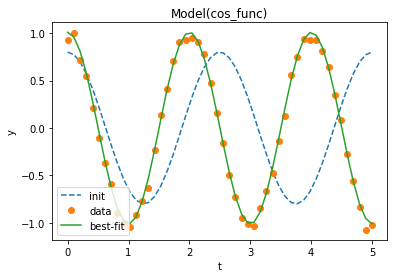

In [15]:
import lmfit
# we create a model based on our function
mod = lmfit.Model(cos_func)
# and specify initial guesses for each parameter
mod.set_param_hint('amplitude', value=.8, vary=True)
mod.set_param_hint('frequency', value=.4)
mod.set_param_hint('phase', value=0, vary=False)
mod.set_param_hint('offset', value=0, vary=False)
params = mod.make_params()
# and here we perform the fit. 
fit_res = mod.fit(dset['y0'].values, t=dset['x0'].values, params=params)


# It is possible to get a quick visualization of our fit using a build-in method of lmfit
fit_res.plot_fit(show_init=True)

In [16]:
fit_res.params

name,value,standard error,relative error,initial value,min,max,vary
amplitude,1.00964194,0.00965337,(0.96%),0.8,-inf,inf,True
frequency,0.49958823,5.3858e-04,(0.11%),0.4,-inf,inf,True
phase,0.00000000,0.00000000,,0,-inf,inf,False
offset,0.00000000,0.00000000,,0,-inf,inf,False


In [17]:
# And we can print an overview of the fitting results
print(fit_res.fit_report())

[[Model]]
    Model(cos_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 50
    # variables        = 2
    chi-square         = 0.11365613
    reduced chi-square = 0.00236784
    Akaike info crit   = -300.330039
    Bayesian info crit = -296.505993
[[Variables]]
    amplitude:  1.00964194 +/- 0.00965337 (0.96%) (init = 0.8)
    frequency:  0.49958823 +/- 5.3858e-04 (0.11%) (init = 0.4)
    phase:      0 (fixed)
    offset:     0 (fixed)


#### Plotting and saving the results of the analysis

In [18]:
# We include some visualization utilities in quantify
from quantify.visualization.SI_utilities import set_xlabel, set_ylabel

Text(0.5, 1.0, '20200923-164157-316-24f9a6\nCosine test')

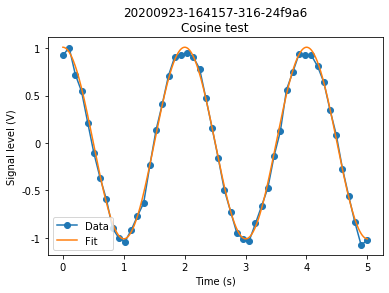

In [19]:
f, ax = plt.subplots()

ax.plot(dset['x0'], dset['y0'], marker='o', label='Data')
x_fit = np.linspace(dset['x0'][0], dset['x0'][-1], 1000)
y_fit = cos_func(t=x_fit, **fit_res.best_values)
ax.plot(x_fit, y_fit, label='Fit')
ax.legend()

set_xlabel(ax, dset['x0'].attrs['long_name'], dset['x0'].attrs['unit'])
set_ylabel(ax, dset['y0'].attrs['long_name'], dset['y0'].attrs['unit'])
ax.set_title('{}\n{}'.format(tuid, 'Cosine test'))

Now that we have analyzed our data and created a figure, we probably want to store the results of our analysis. 
We will want to store the figure and the results of the fit in the `experiment folder`. 


In [44]:
from os.path import join
from quantify.data.handling import create_exp_folder
# Creates a new folder if it does not exist already and return the path to it
# Here we are using this function as a convenient way of retrieving the experiment
# folder without using an absolute path
exp_folder = create_exp_folder(dset.tuid, dset.name)

In [21]:
# Save fit results
lmfit.model.save_modelresult(fit_res, join(exp_folder, 'fit_res.json'))
# Save figure
f.savefig(join(exp_folder, 'Cosine fit.png'), dpi=300, bbox_inches='tight')

## A 2D soft(ware) controlled loop

It is often desired to measure heatmaps (2D grids) of some parameter.
This can be done by specifying two settables.
The setpoints of the grid can be specified in two ways. 

### Method 1 - a quick grid

In [24]:
MC.update_interval(.5)

In [25]:
times = np.linspace(0, 5, 500)
amps = np.linspace(-1, 1, 31)

MC.settables([Settable(t), Settable(amp)])
# MC takes care of creating a meshgrid
MC.setpoints_grid([times, amps])
MC.gettables(Gettable(sig))
dset = MC.run('2D Cosine test')

 100% completed 	elapsed time: 16.6s 	time left: 0.0ss


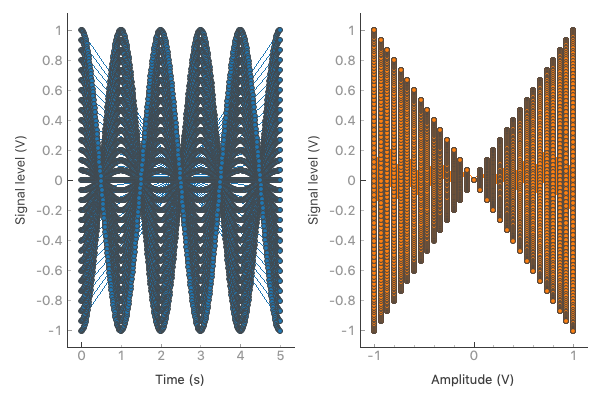

In [26]:
plotmon.main_QtPlot

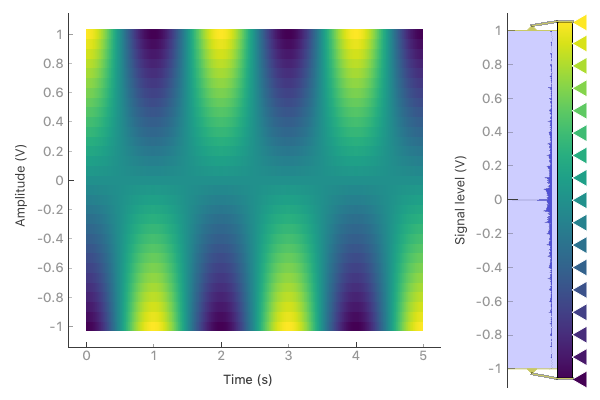

In [27]:
plotmon.secondary_QtPlot

### Method 2 - custom tuples in 2D 

N.B. it is also possible to do this for higher dimensional loops

In [28]:
r = np.linspace(0, 1.5, 2000)
dt = np.linspace(0, 1, 2000)

f = 10

theta = np.cos(2*np.pi*f*dt)
def polar_coords(r, theta):

    x = r*np.cos(2*np.pi*theta)
    y = r*np.sin(2*np.pi*theta)
    return x, y 

x,y = polar_coords(r, theta)
setpoints = np.column_stack([x,y])
setpoints

array([[ 0.00000000e+00, -0.00000000e+00],
       [ 7.50371574e-04, -2.32876698e-06],
       [ 1.50063480e-03, -1.86250865e-05],
       ...,
       [ 1.49838385e+00, -1.85971489e-02],
       [ 1.49924240e+00, -4.65287642e-03],
       [ 1.50000000e+00, -3.67394040e-16]])

In [29]:
acq_delay(0.001)
MC.update_interval(0.5)

In [30]:
MC.settables([t, amp])
MC.setpoints(setpoints)
MC.gettables(sig)
dset = MC.run('2D radial setpoints')

 100% completed 	elapsed time: 14.8s 	time left: 0.0s


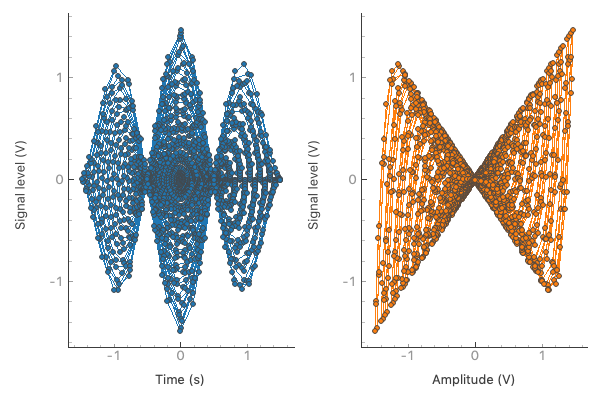

In [31]:
plotmon.main_QtPlot

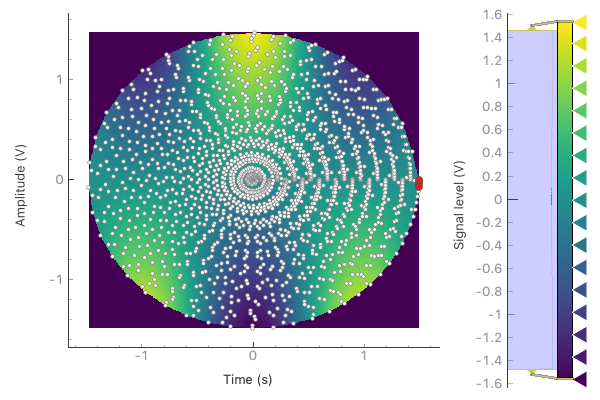

In [32]:
plotmon.secondary_QtPlot